In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from matplotlib.pyplot import figure


import os
import random
import tensorflow.random
os.environ['PYTHONHASHSEED'] = str(1)
random.seed(1)
tensorflow.random.set_seed(1)
np.random.seed(1)

#import sys
import timeit
pd.options.display.max_colwidth = None

In [2]:
df=pd.read_csv("../nasdaq2007_17.csv", delimiter='\t', header=None)
df = df.T
print(f'Number of rows and columns: {df.shape}')
df.head(5)

Number of rows and columns: (3651, 359)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358
0,a,aa,aaba,aapl,abc,abt,abx,adbe,adi,adm,admp,adp,adsk,aee,aem,aep,aes,aet,afl,agn,aig,aiv,all,amat,amd,amgn,amzn,an,antm,apa,apc,apd,aphb,ash,ati,atro,au,avp,avy,axgn,...,tmk,tmo,trow,trxc,ttnp,twx,txn,txt,uis,unh,unm,unp,ups,usb,utx,vfc,viav,vmc,vrsn,vz,wat,wba,wec,wen,wfc,whr,wmb,wmt,wor,wy,x,xel,xl,xlnx,xom,xray,xrx,yum,zbh,zion
1,11.144,47.458,13.88,1.2037,13.991,17.427,15.944,17.97,28.961,9.935,59.33,22.39,8.4,32.215,9.515,20.472,6.3831,12.728,27.98,36.472,1086.56,29.027,31.744,12.377,7.6,54.514,33.05,13.91,36.056,28.226,22.765,36.496,2700,12.412,5.2546,1.4614,28.605,25.005,45.128,2.15,...,16.277,18.673,13.147,30.6,11.44,27.255,16.375,16.111,107.2,21.487,10.634,12.97,51.01,19.985,28.897,7.8957,15.828,34.216,12.397,26.403,26.9,27.645,8.6721,3.8531,20.119,45.222,6.0011,44.983,12.396,14.816,14.514,11.35,72.787,24.126,28.525,17.285,36.388,8.266,46.395,47.669
2,10.471,45.87,12.97,1.1589,13.434,16.694,16.337,16.78,27.597,9.893,62.05,22.093,7.96,32.111,9.815,19.639,6.2966,12.49,27.197,35.61,1047.36,28.573,31.267,11.892,7.21,52.729,31.56,13.41,35.845,27.79,22.489,35.481,2550,12.295,5.228,1.4201,29.598,24.686,44.435,2.05,...,16.033,18.228,12.924,26.25,11.66,26.262,16.528,15.638,101.3,21.225,10.225,12.733,50.958,19.444,28.519,7.7555,14.646,33.795,11.735,26.112,26.19,26.971,8.5002,3.8009,19.771,44.175,5.6829,44.602,12.265,14.534,14.224,11.35,70.884,22.953,28.191,16.901,35.203,8.3172,45.815,46.668
3,10.828,46.249,13.29,1.1385,13.195,16.597,16.776,16.75,27.885,9.944,64.6,22.034,7.74,32.494,9.905,19.991,6.3743,12.94,27.018,34.519,1039.14,28.895,30.827,11.901,7,53.395,31.48,13.5,37.471,27.562,22.469,35.423,2450,12.363,5.228,1.5439,29.588,24.927,44.099,2.46,...,15.59,18.538,13.121,24.05,11.825,26.171,16.52,15.618,99.4,21.561,10.346,12.841,50.764,19.367,28.065,7.7043,14.782,33.776,11.432,26.142,26.8,26.583,8.6229,3.5502,19.695,44.493,5.3936,44.891,12.229,14.267,14.261,11.273,70.817,22.937,28.419,17.016,35.707,8.2781,42.181,46.57
4,10.698,47.852,13.09,1.1437,13.415,16.76,17.069,16.84,28.401,9.925,61.2,22.078,7.63,32.215,10.332,20.16,5.9597,13.143,27.197,35.263,1039.31,29.027,30.604,11.815,7.05,53.108,31.75,13.51,38.121,28.948,23.433,35.371,2400,12.524,5.1921,1.5085,29.81,25.187,44.099,2.15,...,15.646,18.615,13.181,23.1,11.275,26.152,15.829,15.747,102.2,22.048,10.251,12.926,50.788,19.504,28.126,7.6703,14.782,33.669,12.02,26.112,26.41,26.167,8.6876,3.5245,19.665,43.867,5.3358,44.703,12.317,14.24,14.242,11.195,71.314,22.888,28.797,17.421,35.104,8.3591,41.582,46.974


In [3]:
#conv
window_length=10
encoding_dim=3
epochs= 50

def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, 1, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        


In [4]:
x_train_cnn_list = []
x_test_cnn_list = []
s=1
#temp=temp.reshape(-1,1)
#successfully scaled after dayz xD
sc_cnn = []
training_set_scaled_cnn = []

for i in range (0,340):
  sc_cnn.append(MinMaxScaler(feature_range = (0, 1)))
  temp=df[i][1:]
  temp=np.array(temp)
  temp=temp.reshape(-1,1)
  temp = sc_cnn[i].fit_transform(temp)
  training_set_scaled_cnn.append(temp)  
  s=0
  while(s<len(df[0])-1):
    tempo_x_train = temp[s:s+10]
    tempo_x_train=np.asarray(tempo_x_train).astype(np.float32)
    x_train_cnn_list.append(tempo_x_train)
    s=s+10
print(len(x_train_cnn_list))

x_train_final = np.asarray(x_train_cnn_list).astype(np.float32)

print(x_train_final[0*365])
#test
s=1
s=0
x_test_final_cnn_list = []
x_test_final_cnn_list_temp = []
for i in range (340,359):

  sc_cnn.append(MinMaxScaler(feature_range = (0, 1)))
  temp=df[i][1:]
  temp=np.array(temp)
  temp=temp.reshape(-1,1)
  temp = sc_cnn[i].fit_transform(temp)
  training_set_scaled_cnn.append(temp) 
  s=0 
  while(s<len(df[i])-1):


    tempo_x_test = temp[s:s+10]
    tempo_x_test=np.asarray(tempo_x_test).astype(np.float32)
    x_test_cnn_list.append(tempo_x_test)
    x_test_final_cnn_list_temp.append(tempo_x_test)
    s=s+10
  x_test_final_cnn_list.append(list(x_test_final_cnn_list_temp))
  x_test_final_cnn_list_temp = []

x_test_final = np.asarray(x_test_cnn_list).astype(np.float32)
print(len(x_test_final))
for i in range(0,len(x_test_final_cnn_list)):
  x_test_final_cnn_list[i]=np.asarray(x_test_final_cnn_list[i]).astype(np.float32)


124100
[[0.04579599]
 [0.03457418]
 [0.04052691]
 [0.03835925]
 [0.0418942 ]
 [0.0429947 ]
 [0.05301597]
 [0.05861853]
 [0.05850181]
 [0.06403768]]
6935


In [5]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_final, x_train_final,
                epochs=epochs,
                batch_size=256,
                shuffle=True)
#encoder = Model(input_window, encoded)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 16)            64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 16)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 1)              49        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 1)             0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 1)              4   

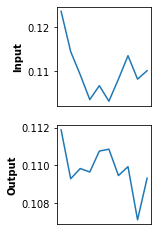

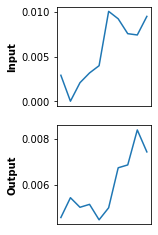

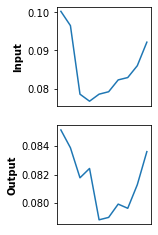

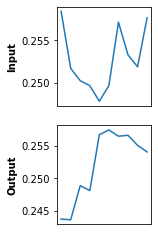

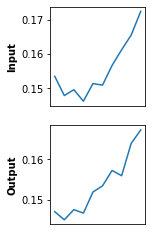

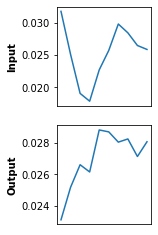

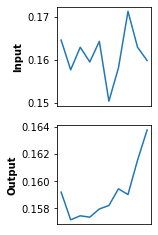

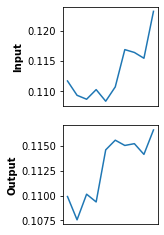

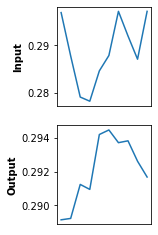

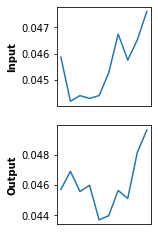

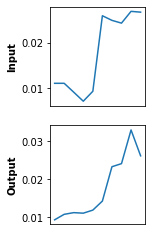

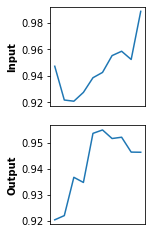

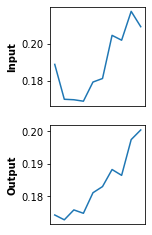

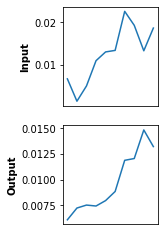

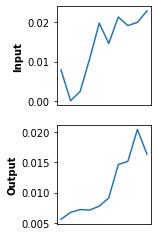

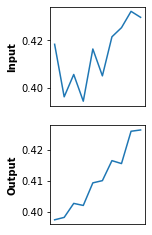

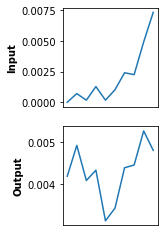

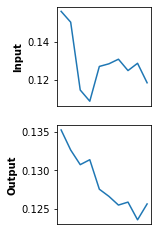

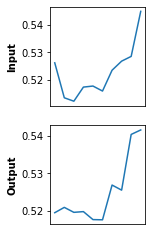

In [6]:
encoder.save("encoder_C.h5")

for i in range(0,len(x_test_final_cnn_list)):
  decoded_stocks = autoencoder.predict(x_test_final_cnn_list[i])
  plot_examples(x_test_final_cnn_list[i],decoded_stocks)